In [1]:
# Install timm (for ViT backbone)
!pip install -q timm

# Import required libraries
import os
import glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import timm
import torch.nn.functional as F
from sklearn.metrics import jaccard_score


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.6 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pylibcugraph-cu12 24.12.0 requires pylibraft-cu12==24.12.*, but you have pylibraft-cu12 25.2.0 which is incompatible.
pylibcugraph-cu12 24.12.0 requires rmm-cu12==24.12.*, but you have 

In [2]:
# Paths as per your structure
train_img_dir = "/kaggle/input/polypdata/new_data/train/images/"
train_mask_dir = "/kaggle/input/polypdata/new_data/train/masks/"

val_img_dir = "/kaggle/input/polypdata/new_data/valid/images/"
val_mask_dir = "/kaggle/input/polypdata/new_data/valid/masks/"

test_img_dir = "/kaggle/input/polypdata/new_data/test/images/"
test_mask_dir = "/kaggle/input/polypdata/new_data/test/masks/"


In [3]:
class PolypDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        self.img_paths = sorted(glob.glob(os.path.join(img_dir, "*.jpg")))
        self.mask_paths = sorted(glob.glob(os.path.join(mask_dir, "*.jpg")))
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        image = Image.open(self.img_paths[idx]).convert("RGB").resize((256, 256))
        mask = Image.open(self.mask_paths[idx]).convert("L").resize((256, 256))
        
        image = np.array(image) / 255.0
        mask = np.array(mask) / 255.0
        mask = (mask > 0.5).astype(np.float32)

        image = torch.from_numpy(image).permute(2, 0, 1).float()
        mask = torch.from_numpy(mask).unsqueeze(0).float()

        return image, mask


In [4]:
import torchvision.transforms as T
import albumentations as A
from albumentations.pytorch import ToTensorV2

def get_train_transforms():
    return A.Compose([
        A.RandomResizedCrop(224, 224, scale=(0.7, 1.2), p=1.0),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.ElasticTransform(p=0.3),
        A.RandomBrightnessContrast(p=0.3),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])


def get_val_transforms():
    return T.Compose([
        T.Resize(256),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Example for ImageNet stats
    ])

In [5]:
train_transforms = get_train_transforms()
val_transforms = get_val_transforms()

train_dataset = PolypDataset(train_img_dir, train_mask_dir)
val_dataset = PolypDataset(val_img_dir, val_mask_dir)
test_dataset = PolypDataset(test_img_dir, test_mask_dir)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


In [6]:
# Dice Loss
def dice_loss(pred, target, smooth=1e-6):
    intersection = torch.sum(pred * target)
    return 1 - (2. * intersection + smooth) / (torch.sum(pred) + torch.sum(target) + smooth)

# IoU Loss
def iou_loss(pred, target, smooth=1e-6):
    intersection = torch.sum(pred * target)
    union = torch.sum(pred) + torch.sum(target) - intersection
    return 1 - (intersection + smooth) / (union + smooth)

# Combined Loss function
def combined_loss(pred, target):
    dice = dice_loss(pred, target)
    iou = iou_loss(pred, target)
    return dice + iou


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import timm

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3)  # Dropout layer added for regularization
        )
    
    def forward(self, x):
        return self.conv(x)


# Decoder block with upsampling + skip connection + conv
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels):
        super(DecoderBlock, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv = ConvBlock(skip_channels + out_channels, out_channels)
    
    def forward(self, x, skip):
        x = self.up(x)
        # Match spatial dimensions
        diffY = skip.size()[2] - x.size()[2]
        diffX = skip.size()[3] - x.size()[3]
        x = F.pad(x, [diffX // 2, diffX - diffX // 2,
                      diffY // 2, diffY - diffY // 2])
        x = torch.cat([skip, x], dim=1)
        return self.conv(x)

# TransUNet with ViT encoder and CNN decoder
class TransUNet(nn.Module):
    def __init__(self, img_size=256, in_channels=3, num_classes=1):
        super(TransUNet, self).__init__()
        self.img_size = img_size
        
        # Load pretrained ViT encoder
        self.vit = timm.create_model('vit_base_patch16_224', pretrained=True, features_only=False, num_classes=0)
        vit_features = self.vit.embed_dim  # 768 for base ViT

        # Project transformer features to start decoder
        self.conv_proj = nn.Conv2d(vit_features, 512, kernel_size=1)

        # Decoder blocks
        self.decoder1 = DecoderBlock(512, 256, 256)
        self.decoder2 = DecoderBlock(256, 128, 128)
        self.decoder3 = DecoderBlock(128, 64, 64)
        self.decoder4 = DecoderBlock(64, 32, 32)

        # Skip projection from ViT features
        self.skip1 = nn.Conv2d(vit_features, 256, kernel_size=1)
        self.skip2 = nn.Conv2d(vit_features, 128, kernel_size=1)
        self.skip3 = nn.Conv2d(vit_features, 64, kernel_size=1)
        self.skip4 = nn.Conv2d(vit_features, 32, kernel_size=1)

        # Final classifier layer
        self.final = nn.Conv2d(32, num_classes, kernel_size=1)

    def forward(self, x):
        B, C, H, W = x.shape

        # Resize input for ViT
        x_resized = F.interpolate(x, size=(224, 224), mode='bilinear', align_corners=True)

        # Extract features
        vit_features = self.vit.forward_features(x_resized)  # Shape: [B, N, D]

        # Convert patch sequence to 2D spatial map
        vit_spatial = vit_features[:, 1:, :].reshape(B, -1, 14, 14)

        # Project to 512 channels for decoder start
        x = self.conv_proj(vit_spatial)

        # Generate skip connections from ViT
        skip1 = self.skip1(vit_spatial)                        # 14x14
        skip2 = self.skip2(F.interpolate(vit_spatial, scale_factor=2))  # 28x28
        skip3 = self.skip3(F.interpolate(vit_spatial, scale_factor=4))  # 56x56
        skip4 = self.skip4(F.interpolate(vit_spatial, scale_factor=8))  # 112x112

        # Decoder path
        d1 = self.decoder1(x, skip1)      # 14x14 -> 28x28
        d2 = self.decoder2(d1, skip2)     # 28x28 -> 56x56
        d3 = self.decoder3(d2, skip3)     # 56x56 -> 112x112
        d4 = self.decoder4(d3, skip4)     # 112x112 -> 224x224

        # Final 1x1 convolution
        output = self.final(d4)

        # Upsample to match original input size
        output = F.interpolate(output, size=(H, W), mode='bilinear', align_corners=True)

        return output


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TransUNet().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [9]:
import torch
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR

# Define the combined loss function (Dice + IoU)

# Train the model
def train_model(model, train_loader, val_loader, optimizer, epochs=50, device="cuda"):
    best_dice = 0
    scheduler = StepLR(optimizer, step_size=10, gamma=0.5)  # Learning Rate Scheduler
    
    # Initialize weights using He initialization
    def init_weights(m):
        if isinstance(m, torch.nn.Conv2d):
            torch.nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        elif isinstance(m, torch.nn.BatchNorm2d):
            torch.nn.init.constant_(m.weight, 1)
            torch.nn.init.constant_(m.bias, 0)

    model.apply(init_weights)  # Apply weight initialization
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for imgs, masks in train_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            optimizer.zero_grad()
            
            # Forward pass
            preds = model(imgs)
            pred_mask = torch.sigmoid(preds)  # Sigmoid activation
            
            # Calculate loss
            loss = combined_loss(pred_mask, masks)
            
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        # Validation phase
        model.eval()
        val_dice = 0
        with torch.no_grad():
            for imgs, masks in val_loader:
                imgs, masks = imgs.to(device), masks.to(device)
                
                # Get model prediction
                preds = model(imgs)
                pred_mask = (torch.sigmoid(preds) > 0.5).float()  # Apply threshold
                
                # Calculate Dice score
                val_dice += 1 - dice_loss(pred_mask, masks).item()
        
        val_dice /= len(val_loader)  # Calculate average Dice score for validation
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_loader):.4f}, Val Dice: {val_dice:.4f}")

        # Step the scheduler
        scheduler.step()

        # Save the best model based on validation Dice score
        if val_dice > best_dice:
            best_dice = val_dice
            torch.save(model.state_dict(), "best_transunet.pth")



In [10]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
train_model(model, train_loader, val_loader, optimizer, epochs=100, device="cuda")


Epoch 1/100, Train Loss: 1.3427, Val Dice: 0.4166
Epoch 2/100, Train Loss: 1.2923, Val Dice: 0.4175
Epoch 3/100, Train Loss: 1.2900, Val Dice: 0.4176
Epoch 4/100, Train Loss: 1.2882, Val Dice: 0.4206
Epoch 5/100, Train Loss: 1.2817, Val Dice: 0.4219
Epoch 6/100, Train Loss: 1.2656, Val Dice: 0.4366
Epoch 7/100, Train Loss: 1.2420, Val Dice: 0.4517
Epoch 8/100, Train Loss: 1.2161, Val Dice: 0.4586
Epoch 9/100, Train Loss: 1.1739, Val Dice: 0.4686
Epoch 10/100, Train Loss: 1.1502, Val Dice: 0.4744
Epoch 11/100, Train Loss: 1.0965, Val Dice: 0.4968
Epoch 12/100, Train Loss: 1.0608, Val Dice: 0.4928
Epoch 13/100, Train Loss: 1.0477, Val Dice: 0.4897
Epoch 14/100, Train Loss: 1.0050, Val Dice: 0.4889
Epoch 15/100, Train Loss: 0.9816, Val Dice: 0.5054
Epoch 16/100, Train Loss: 0.9174, Val Dice: 0.5034
Epoch 17/100, Train Loss: 0.8794, Val Dice: 0.5021
Epoch 18/100, Train Loss: 0.8394, Val Dice: 0.5004
Epoch 19/100, Train Loss: 0.8090, Val Dice: 0.5126
Epoch 20/100, Train Loss: 0.7794, Val Di

/tmp/ipykernel_31/3769137846.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_transunet.pth"))


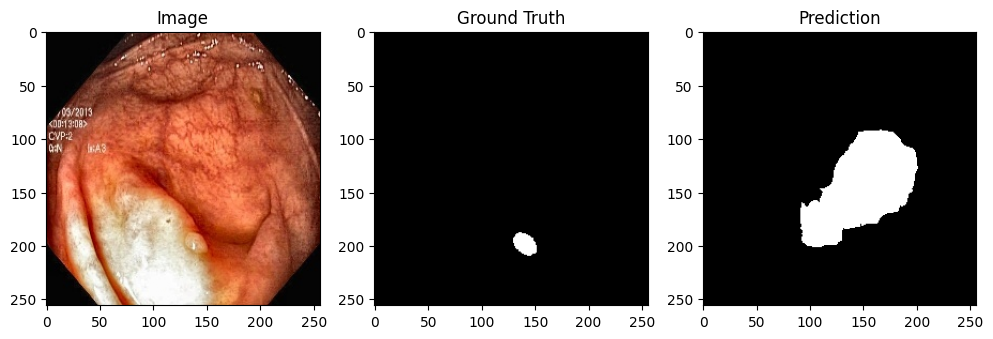

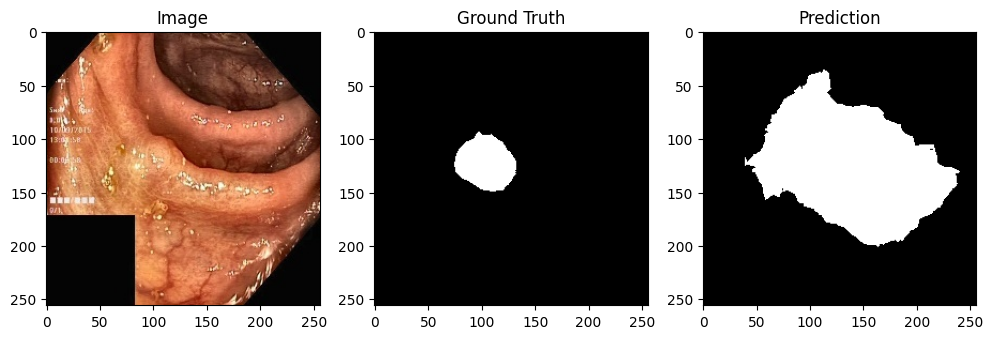

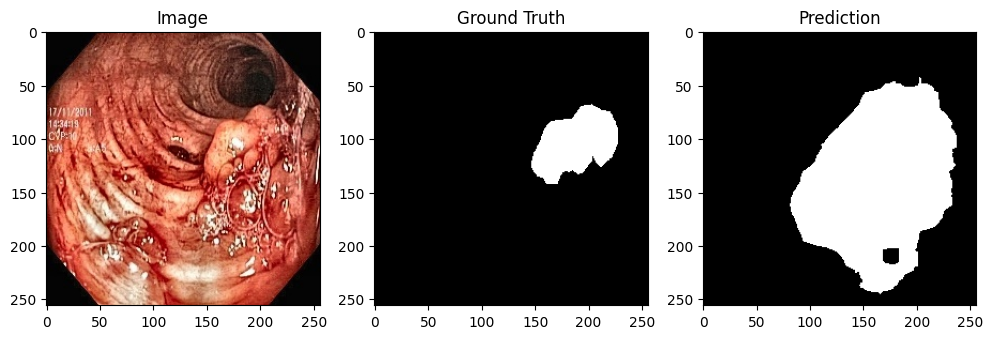

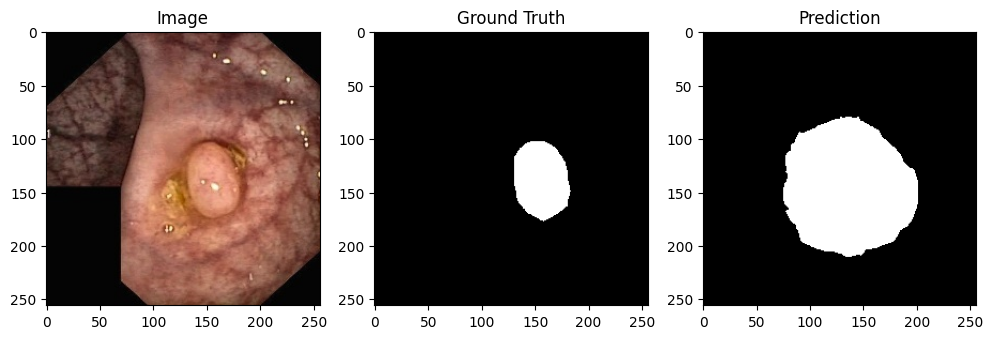

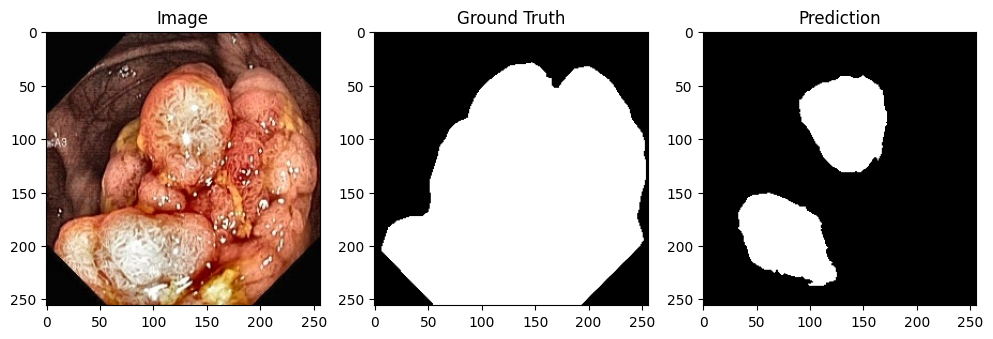

In [11]:
# Load best model
model.load_state_dict(torch.load("best_transunet.pth"))
model.eval()

# Visualize predictions
def show_predictions(model, loader, num=5):
    model.eval()
    count = 0
    with torch.no_grad():
        for imgs, masks in loader:
            imgs = imgs.to(device)
            preds = model(imgs)
            preds = (torch.sigmoid(preds) > 0.5).float()

            for i in range(imgs.size(0)):
                img = imgs[i].cpu().permute(1,2,0).numpy()
                mask = masks[i][0].cpu().numpy()
                pred = preds[i][0].cpu().numpy()

                fig, ax = plt.subplots(1, 3, figsize=(12, 4))
                ax[0].imshow(img)
                ax[0].set_title('Image')
                ax[1].imshow(mask, cmap='gray')
                ax[1].set_title('Ground Truth')
                ax[2].imshow(pred, cmap='gray')
                ax[2].set_title('Prediction')
                plt.show()

                count += 1
                if count >= num:
                    return

show_predictions(model, test_loader, num=5)
